In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers


In [27]:
# load dataset
train = pd.read_csv('mnist_train.csv')
test = pd.read_csv('mnist_test.csv')

train

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
x_train=train.iloc[:,1:].values
x_test=test.iloc[:,1:].values
y_train=train['label'].values
y_test=test['label'].values
x_train[6,:].shape

(784,)

In [29]:
# Preprocess the data
x_train = x_train.reshape((-1, 28, 28, 1)) / 255.0  # Reshape and normalize training images
x_test = x_test.reshape((-1, 28, 28, 1)) / 255.0    # Reshape and normalize test images

In [30]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

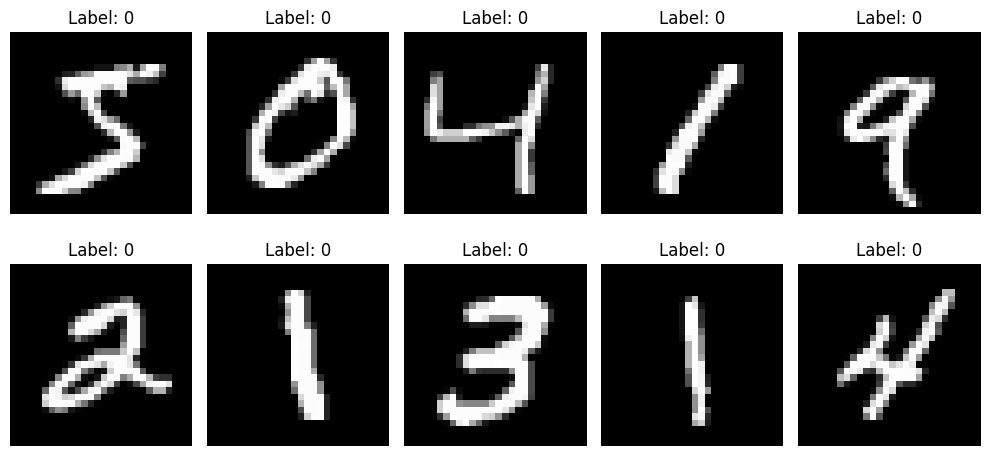

In [31]:
# Visualize sample images from the dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()
for i in range(10):
    axes[i].imshow(x_train[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f"Label: {np.argmax(y_train[i])}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [32]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 10

In [33]:
inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)

z_log_sigma = layers.Dense(latent_dim)(h)
print(z_mean.shape)

(None, 10)


In [34]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [35]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [36]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense_7 (Dense)             (None, 64)                   50240     ['input_2[0][0]']             
                                                                                                  
 dense_8 (Dense)             (None, 10)                   650       ['dense_7[0][0]']             
                                                                                                  
 dense_9 (Dense)             (None, 10)                   650       ['dense_7[0][0]']             
                                                                                            

In [37]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [38]:
vae.compile(optimizer='adam',loss='binary_crossentropy')

In [39]:
vae.fit(x_train, x_train,
        epochs=15,
        batch_size=32)

Epoch 1/15
1875/1875 [==============================] - 6s 3ms/step - loss: 147.0480
Epoch 2/15
1875/1875 [==============================] - 5s 3ms/step - loss: 116.2787
Epoch 3/15
1875/1875 [==============================] - 5s 3ms/step - loss: 110.0751
Epoch 4/15
1875/1875 [==============================] - 5s 2ms/step - loss: 106.7366
Epoch 5/15
1875/1875 [==============================] - 5s 3ms/step - loss: 104.7021
Epoch 6/15
1875/1875 [==============================] - 5s 2ms/step - loss: 103.2513
Epoch 7/15
1875/1875 [==============================] - 5s 2ms/step - loss: 102.2284
Epoch 8/15
1875/1875 [==============================] - 5s 3ms/step - loss: 101.4584
Epoch 9/15
1875/1875 [==============================] - 5s 3ms/step - loss: 100.8375
Epoch 10/15
1875/1875 [==============================] - 5s 3ms/step - loss: 100.3246
Epoch 11/15
1875/1875 [==============================] - 5s 3ms/step - loss: 99.9351
Epoch 12/15
1875/1875 [==============================] - 5s 3ms/

In [40]:
x_decoded = vae.predict(x_train)

1875/1875 [==============================] - 2s 1ms/step


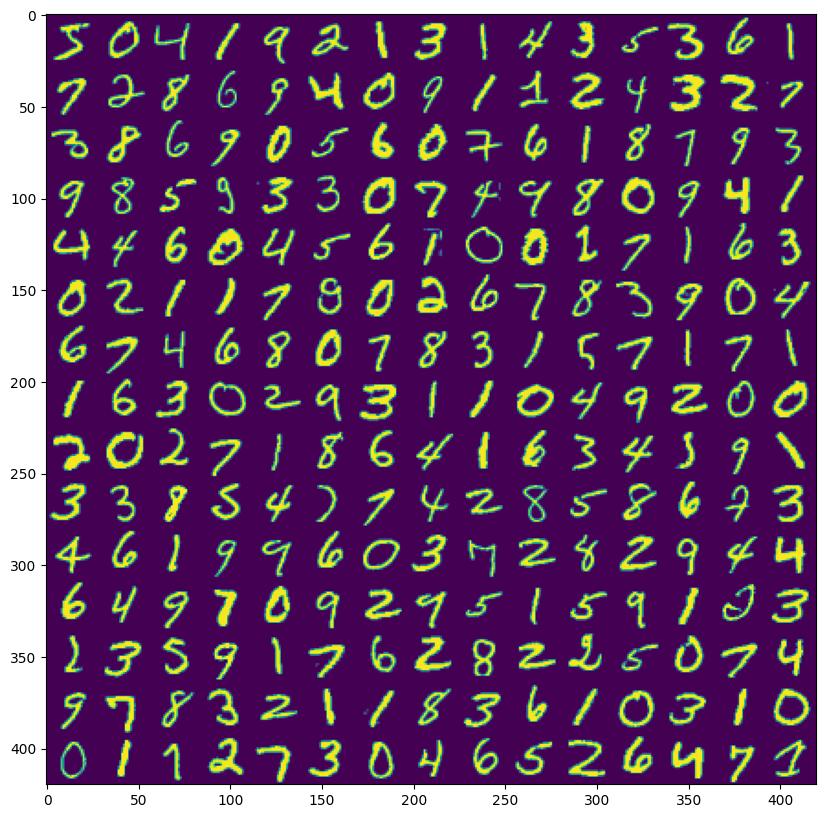

225


In [41]:
import matplotlib.pyplot as plt
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        digit = x_train[k].reshape(digit_size, digit_size)
        k = k +1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()
print (k)

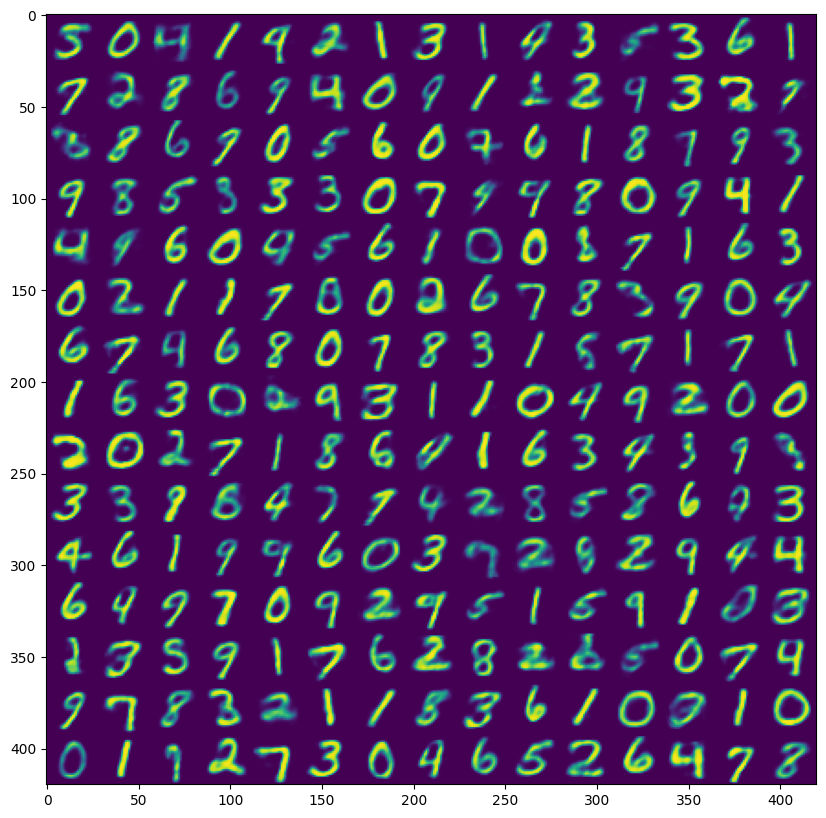

In [42]:
import matplotlib.pyplot as plt
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        digit = x_decoded[k].reshape(digit_size, digit_size)
        k = k +1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()